In [1]:
!nvidia-smi
!pip -q install opencv-python matplotlib torch torchvision
!pip -q install git+https://github.com/facebookresearch/segment-anything.git

Fri Jan  9 18:18:35 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!mkdir -p checkpoints
!wget -q -O checkpoints/sam_vit_b_01ec64.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
!ls -lh checkpoints

total 358M
-rw-r--r-- 1 root root 358M Apr  4  2023 sam_vit_b_01ec64.pth


In [3]:
import os, glob
import numpy as np
import cv2
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from segment_anything import sam_model_registry, SamPredictor

In [4]:
# Učitaj SAM (ViT-B)
sam_checkpoint = "checkpoints/sam_vit_b_01ec64.pth"
model_type = "vit_b"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device="cuda" if torch.cuda.is_available() else "cpu")

predictor = SamPredictor(sam)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# =========================
# CONFIG
# =========================
TARGET_H, TARGET_W = 512, 256  # ista rezolucija kao u tvojim U-Net eksperimentima

FLUID_IDS = {
    "PED": 5,
    "SRF": 6,
    "IRF": 7
}

# Jedan fold (promijeni na svoj)
patient_id = "24F"
img_dir  = f"/content/drive/MyDrive/Colab Notebooks/AROI/LOOCV/{patient_id}/test/raw"
mask_dir = f"/content/drive/MyDrive/Colab Notebooks/AROI/LOOCV/{patient_id}/test/mask"

# SAM prompt config
BOX_MARGIN = 0  # prema tvojim preliminarnim rezultatima


In [7]:
def list_pairs(img_dir: str, mask_dir: str, exts=(".png", ".jpg", ".jpeg")):
    img_paths = []
    for ext in exts:
        img_paths += glob.glob(os.path.join(img_dir, f"*{ext}"))
    img_paths = sorted(img_paths)

    pairs = []
    for ip in img_paths:
        fname = os.path.basename(ip)          # npr. patient5_raw0038.png
        mp = os.path.join(mask_dir, fname)    # isti naziv u mask folderu
        if os.path.exists(mp):
            pairs.append((ip, mp))
    return pairs

def load_image_mask(img_path: str, mask_path: str, target_hw=(512,256)):
    # raw slika (grayscale ili RGB)
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Can't read image: {img_path}")

    # maska (numerička 0..7)
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    if mask is None:
        raise FileNotFoundError(f"Can't read mask: {mask_path}")
    if mask.ndim == 3:
        mask = mask[:, :, 0]
    mask = mask.astype(np.uint8)

    th, tw = target_hw

    # resize image
    if img.ndim == 2:
        img = cv2.resize(img, (tw, th), interpolation=cv2.INTER_AREA)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # SAM treba 3 kanala
    else:
        if img.shape[2] == 4:
            img = img[:, :, :3]
        img = cv2.resize(img, (tw, th), interpolation=cv2.INTER_AREA)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # resize mask (nearest!)
    mask = cv2.resize(mask, (tw, th), interpolation=cv2.INTER_NEAREST)

    # sanity
    if img_rgb.shape[:2] != mask.shape:
        raise ValueError(f"Shape mismatch: image {img_rgb.shape[:2]} vs mask {mask.shape}")

    return img_rgb, mask

def binary_for_fluid(mask: np.ndarray, fluid_id: int):
    bm = (mask == fluid_id).astype(np.uint8)
    if bm.sum() == 0:
        return None
    return bm

def bbox_from_binary(bm: np.ndarray, margin: int = 0):
    ys, xs = np.where(bm > 0)
    if len(xs) == 0:
        return None
    h, w = bm.shape
    x0, x1 = int(xs.min()), int(xs.max())
    y0, y1 = int(ys.min()), int(ys.max())

    x0 = max(0, x0 - margin)
    y0 = max(0, y0 - margin)
    x1 = min(w - 1, x1 + margin)
    y1 = min(h - 1, y1 + margin)

    return (x0, y0, x1, y1)

def dice_iou(gt: np.ndarray, pred: np.ndarray):
    gt = gt.astype(bool)
    pred = pred.astype(bool)

    inter = (gt & pred).sum()
    denom = gt.sum() + pred.sum()
    dice = (2 * inter) / (denom + 1e-8)

    union = (gt | pred).sum()
    iou = inter / (union + 1e-8)

    return float(dice), float(iou)

def sam_predict_box(predictor, image_rgb: np.ndarray, box_xyxy):
    """
    predictor: SamPredictor (already created)
    image_rgb: (H,W,3) uint8
    box_xyxy: (x0,y0,x1,y1)
    """
    predictor.set_image(image_rgb)
    box = np.array(box_xyxy)

    masks, scores, _ = predictor.predict(
        box=box,
        multimask_output=True
    )

    best = int(np.argmax(scores))
    return masks[best].astype(np.uint8), scores



In [8]:
# =========================
# EVALUATION: ONE FOLD
# =========================
def eval_one_fold(predictor, img_dir, mask_dir, margin=0, max_images=None):
    pairs = list_pairs(img_dir, mask_dir)
    if max_images is not None:
        pairs = pairs[:max_images]

    rows = []
    for img_path, mask_path in pairs:
        image_rgb, mask = load_image_mask(img_path, mask_path, target_hw=(TARGET_H, TARGET_W))
        fname = os.path.basename(img_path)

        for fluid_name, fluid_id in FLUID_IDS.items():
            bm = binary_for_fluid(mask, fluid_id)
            if bm is None:
                # IGNORE: nema tekućine -> ne ulazi u prosjek
                continue

            box = bbox_from_binary(bm, margin=margin)
            if box is None:
                continue

            pred_mask, scores = sam_predict_box(predictor, image_rgb, box)
            d, j = dice_iou(bm, pred_mask)

            rows.append({
                "image": fname,
                "fluid": fluid_name,
                "gt_pixels": int(bm.sum()),
                "pred_pixels": int(pred_mask.sum()),
                "dice": d,
                "iou": j,
                "sam_score_best": float(np.max(scores)),
                "margin": margin
            })

    return pd.DataFrame(rows)

def summarize_by_fluid(df: pd.DataFrame):
    if df.empty:
        return df
    return (
        df.groupby("fluid")[["dice","iou"]]
          .agg(["mean","std","count"])
          .reset_index()
    )



In [9]:
# =========================
# RUN
# =========================
df = eval_one_fold(predictor, img_dir, mask_dir, margin=0, max_images=None)
print("Rows:", len(df))
summary = summarize_by_fluid(df)
summary

Rows: 28


fluid      dice                       iou                
             mean       std count      mean       std count
0   PED  0.929105  0.077405    24  0.876058  0.122298    24
1   SRF  0.530745  0.154763     4  0.372249  0.139882     4

In [9]:
def load_image_mask_by_scan(img_dir, mask_dir, scan_number, resize_to=(TARGET_H, TARGET_W)):
    """
    scan_number: npr. 38 ili "0038"
    traži file koji sadrži 'rawXXXX' gdje je XXXX 4-znamenkasti broj
    """
    scan_str = f"{int(scan_number):04d}" if isinstance(scan_number, (int, np.integer)) else str(scan_number).zfill(4)

    # nađi raw file koji završava s rawXXXX.png (ili sadrži rawXXXX u imenu)
    pattern = os.path.join(img_dir, f"*raw{scan_str}.png")
    matches = sorted(glob.glob(pattern))
    if len(matches) == 0:
        raise FileNotFoundError(f"Nisam našao raw sliku za scan {scan_str} u {img_dir}")

    img_path = matches[0]
    fname = os.path.basename(img_path)
    mask_path = os.path.join(mask_dir, fname)
    if not os.path.exists(mask_path):
        raise FileNotFoundError(f"Nisam našao masku: {mask_path}")

    # učitaj raw
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Ne mogu učitati sliku: {img_path}")

    # grayscale -> RGB
    if img.ndim == 2:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:
        if img.shape[2] == 4:
            img = img[:, :, :3]
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # učitaj masku (numerička 0..7)
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    if mask is None:
        raise FileNotFoundError(f"Ne mogu učitati masku: {mask_path}")
    if mask.ndim == 3:
        mask = mask[:, :, 0]
    mask = mask.astype(np.uint8)

    # resize na (512,256) kao u evaluaciji
    if resize_to is not None:
        th, tw = resize_to
        img_rgb = cv2.resize(img_rgb, (tw, th), interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, (tw, th), interpolation=cv2.INTER_NEAREST)

    return img_rgb, mask, fname


In [10]:
FLUID_COLORS = {
    "PED": (1.0, 0.9, 0.0, 0.55),
    "SRF": (1.0, 0.0, 0.0, 0.55),
    "IRF": (0.0, 1.0, 0.0, 0.55),
}

def list_available_scans(img_dir, limit=None):
    files = sorted(glob.glob(os.path.join(img_dir, "*raw*.png")))
    scans = []
    for f in files:
        name = os.path.basename(f)
        idx = name.find("raw")
        if idx != -1 and idx + 7 <= len(name):
            scans.append(name[idx+3:idx+7])
    scans = sorted(set(scans))
    print("Found", len(scans), "scans:", scans[:limit] if limit else scans)
    return scans

def gt_masks_per_fluid(mask):
    """Vrati dict {fluid_name: binary_mask} samo za fluide koji postoje u GT."""
    out = {}
    for name, fid in FLUID_IDS.items():
        bm = (mask == fid).astype(np.uint8)
        if bm.sum() > 0:
            out[name] = bm
    return out

def bbox_from_binary_mask(bm, margin=0):
    ys, xs = np.where(bm > 0)
    if len(xs) == 0:
        return None
    h, w = bm.shape
    x0, x1 = int(xs.min()), int(xs.max())
    y0, y1 = int(ys.min()), int(ys.max())
    x0 = max(0, x0 - margin); y0 = max(0, y0 - margin)
    x1 = min(w - 1, x1 + margin); y1 = min(h - 1, y1 + margin)
    return (x0, y0, x1, y1)

def make_rgba_overlay(binary_masks_dict, shape_hw):
    """binary_masks_dict: {name: (H,W) 0/1} -> RGBA overlay (H,W,4)"""
    h, w = shape_hw
    overlay = np.zeros((h, w, 4), dtype=np.float32)
    for name, bm in binary_masks_dict.items():
        m = (bm > 0)
        r, g, b, a = FLUID_COLORS[name]
        overlay[m, 0] = r
        overlay[m, 1] = g
        overlay[m, 2] = b
        overlay[m, 3] = a
    return overlay

def draw_bboxes(ax, boxes_dict):
    for name, box in boxes_dict.items():
        if box is None:
            continue
        x0, y0, x1, y1 = box
        r, g, b, _ = FLUID_COLORS[name]
        rect = patches.Rectangle((x0, y0), x1-x0, y1-y0,
                                 linewidth=2, edgecolor=(r,g,b,1.0), facecolor='none')
        ax.add_patch(rect)

def sam_masks_per_fluid(predictor, image_rgb, gt_masks_dict, margin=0):
    """
    Pokreće SAM zasebno za svaki fluid koji postoji u GT (oracle bbox prompt).
    Vraća:
      sam_dict: {fluid_name: sam_mask}
      box_dict: {fluid_name: bbox}
    """
    predictor.set_image(image_rgb)

    sam_dict = {}
    box_dict = {}

    for name, gt_bm in gt_masks_dict.items():
        box = bbox_from_binary_mask(gt_bm, margin=margin)
        box_dict[name] = box
        if box is None:
            continue

        box_np = np.array(box)
        masks, scores, _ = predictor.predict(box=box_np, multimask_output=True)
        best = int(np.argmax(scores))
        sam_dict[name] = masks[best].astype(np.uint8)

    return sam_dict, box_dict

def show_all_fluids_row_with_bbx(image_rgb, mask, predictor, margin=0, title_prefix=""):
    """
    4 panela:
    Raw | GT fluids (colored) | Bounding boxes | SAM fluids (colored)
    """
    h, w = mask.shape

    gt_dict = gt_masks_per_fluid(mask)           # {PED/SRF/IRF: gt_binary}
    sam_dict, box_dict = sam_masks_per_fluid(predictor, image_rgb, gt_dict, margin=margin)

    gt_overlay = make_rgba_overlay(gt_dict, (h,w))
    sam_overlay = make_rgba_overlay(sam_dict, (h,w))

    plt.figure(figsize=(24,10))

    # 1) Raw
    ax1 = plt.subplot(1,4,1)
    ax1.imshow(image_rgb)
    ax1.set_title("Raw")
    ax1.axis("off")

    # 2) GT colored overlay
    ax2 = plt.subplot(1,4,2)
    ax2.imshow(image_rgb)
    ax2.imshow(gt_overlay)     # transparentno, bez tintanja pozadine
    ax2.set_title("GT fluids (PED=B, SRF=R, IRF=G)")
    ax2.axis("off")

    # 3) BBoxes
    ax3 = plt.subplot(1,4,3)
    ax3.imshow(image_rgb)
    draw_bboxes(ax3, box_dict)
    ax3.set_title(f"Bounding-box prompts (margin={margin})")
    ax3.axis("off")

    # 4) SAM colored overlay
    ax4 = plt.subplot(1,4,4)
    ax4.imshow(image_rgb)
    ax4.imshow(sam_overlay)    # transparentno, bez tintanja pozadine
    ax4.set_title("SAM fluids (colored)")
    ax4.axis("off")

    plt.suptitle(f"{title_prefix}  Computed SAM masks: {list(sam_dict.keys())}", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()


In [30]:
patient_id = "12F"
img_dir_patient  = f"/content/drive/MyDrive/Colab Notebooks/AROI/LOOCV/{patient_id}/test/raw"
mask_dir_patient = f"/content/drive/MyDrive/Colab Notebooks/AROI/LOOCV/{patient_id}/test/mask"

In [31]:
def list_available_scans(img_dir, limit=None):
    files = sorted(glob.glob(os.path.join(img_dir, "*raw*.png")))
    scans = []
    for f in files:
        name = os.path.basename(f)
        idx = name.find("raw")
        if idx != -1 and idx + 7 <= len(name):
            scans.append(name[idx+3:idx+7])
    scans = sorted(set(scans))

    print("Found", len(scans), "scans. First:", scans[:limit] if limit else scans)
    return scans

scans = list_available_scans(img_dir_patient)

Found 19 scans. First: ['0058', '0059', '0060', '0061', '0062', '0063', '0065', '0066', '0067', '0068', '0069', '0070', '0071', '0072', '0073', '0074', '0075', '0076', '0077']


Loaded: patient12_raw0067.png (512, 256, 3) (512, 256) unique: [0 1 2 3 4 5 7]


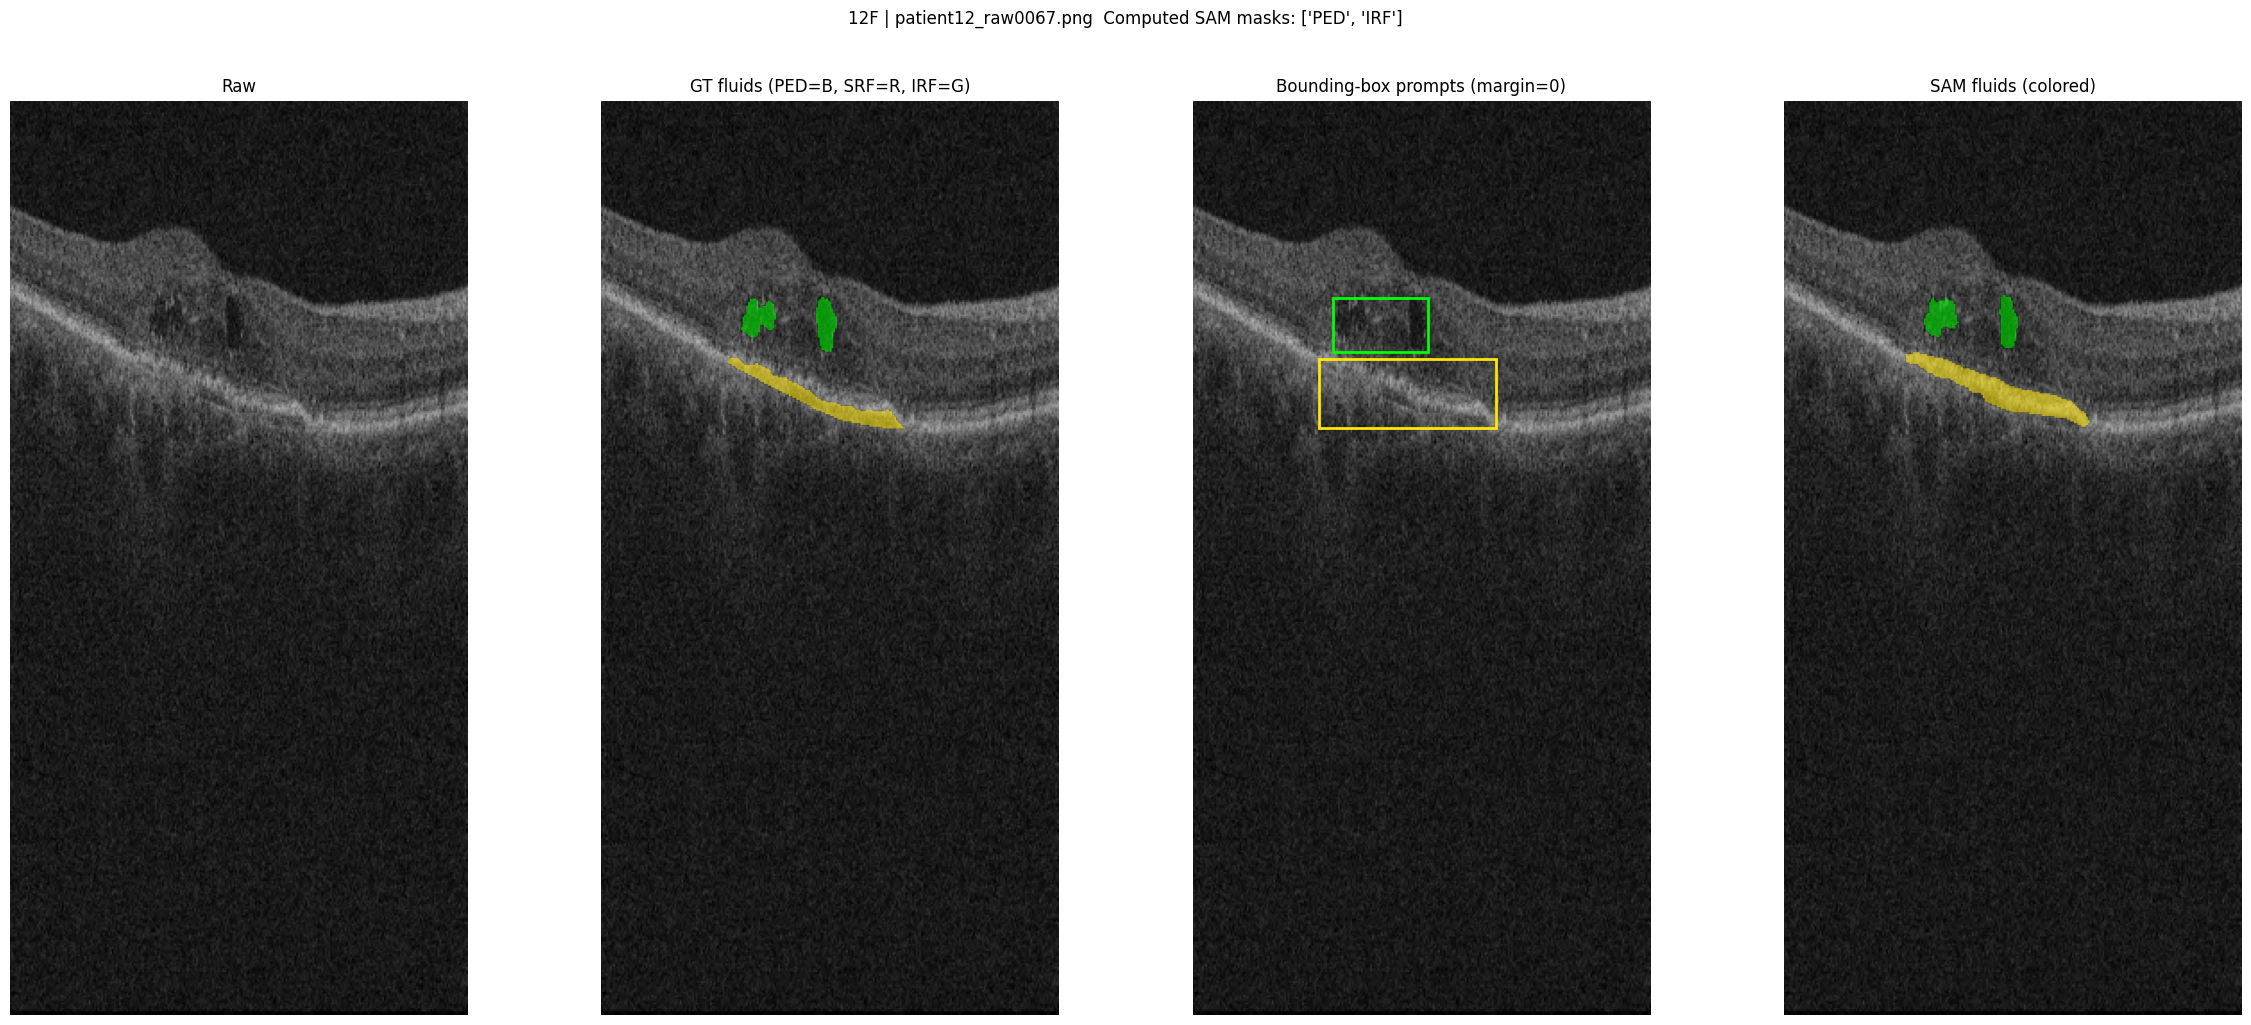

In [32]:
scan_no = 67
image_rgb, mask, fname = load_image_mask_by_scan(img_dir_patient, mask_dir_patient, scan_no)

print("Loaded:", fname, image_rgb.shape, mask.shape, "unique:", np.unique(mask))

show_all_fluids_row_with_bbx(image_rgb, mask, predictor, margin=0, title_prefix=f"{patient_id} | {fname}")

PED: 24 SRF: 21 IRF: 12


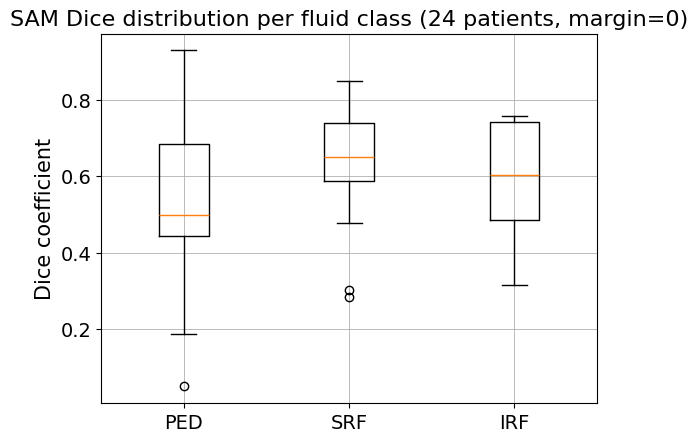

In [8]:
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 15,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14
})

df = pd.read_excel("box_plot.xlsx")

dice_PED = df["PED_mean_dice"].dropna().values
dice_SRF = df["SRF_mean_dice"].dropna().values
dice_IRF = df["IRF_mean_dice"].dropna().values

print("PED:", len(dice_PED), "SRF:", len(dice_SRF), "IRF:", len(dice_IRF))

plt.figure()
plt.boxplot([dice_PED, dice_SRF, dice_IRF], tick_labels=["PED", "SRF", "IRF"])
plt.ylabel("Dice coefficient")
plt.title("SAM Dice distribution per fluid class (24 patients, margin=0)")
plt.grid(True, linewidth=0.6)
plt.show()